# This is the Coursera capstone project (Seattle collisions data)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
#https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0
dfOriginal = pd.read_csv('Data-Collisions.csv')

C:\Users\carniato\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Create train and test dataset

Use startified samples, to get the same distributions of targets in train and test set

In [4]:
df=dfOriginal.copy()
y = df['SEVERITYCODE']
X = df.drop(['SEVERITYCODE'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)

train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

# Data cleaning

Inspect data first

In [5]:
def computeDetails(df): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    
    cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration']
    details = pd.concat([types, counts, distincts, nulls, missing_ration], axis = 1)
    details.columns = cols
    
    return details

def GetIndexses(df,col_missing_data,missingValue):
    if not missingValue :
        # nan
        indexses = df[col_missing_data].isnull()
    else:
        # comparables
        indexses = df[col_missing_data]==missingValue
        
    return indexses

def InputMissingData(df, col_missing_data, col_ref, missingValue = None):
    #group by nan or missing value
    invalid_idxs = GetIndexses(df, col_missing_data, missingValue)
    df_notval = df[invalid_idxs]
    df_notval = df_notval.groupby(col_ref).sum()  
    #print(df_notval[col_ref])
    #the valid entries
    df_val = df[~invalid_idxs]
    
    #now check the values of the reference column
    for r in df_notval.index.values:
        if isinstance(r, str) or isinstance(r, np.int64) :
            #a string (e.g. a location)
            df_loc = df_val[df_val[col_ref]==r]
        elif len(r)==2:
            #two doubles
            df_loc = df_val[(df_val[col_ref[0]]==r[0]) & (df_val[col_ref[1]]==r[1])]
        
        if len(df_loc) > 0:
            val = df_loc[col_missing_data].iloc[0]
            if isinstance(r, str) or isinstance(r, np.int64) :
                #substitute with the first valid value
                df.loc[(df[col_ref]==r) & invalid_idxs,col_missing_data]=val
            elif len(r) ==2:
                df.loc[(df[col_ref[0]]==r[0]) &(df[col_ref[1]]==r[1]) & invalid_idxs, col_missing_data] = val
        
    return df     

def bar_chart(datafr, feature):
    severityOne = datafr[datafr['SEVERITYCODE']==1][feature].value_counts()
    #print(severityOne[0]/(severityOne[0] + severityOne[1]))
    severityTwo = datafr[datafr['SEVERITYCODE']==2][feature].value_counts()
    #print(severityTwo[0]/(severityTwo[0] + severityTwo[1]))
    df = pd.DataFrame([severityOne,severityTwo])
    df.index = ['SEVERITYCODE 1','SEVERITYCODE 2']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    
from sklearn.preprocessing import LabelEncoder
def prepare_categorical(train_label, test_label):
    le = LabelEncoder()
    le.fit(train_label)
    train_label_enc = le.transform(train_label)
    test_label_enc = le.transform(test_label)
    return train_label_enc, test_label_enc

In [6]:
details = computeDetails(train)
print(details)

                  types  counts  distincts   nulls  missing ration
X               float64  126901      20954    3529           2.706
Y               float64  126901      21200    3529           2.706
OBJECTID          int64  130430     130430       0           0.000
INCKEY            int64  130430     130430       0           0.000
COLDETKEY         int64  130430     130430       0           0.000
REPORTNO         object  130430     130428       0           0.000
STATUS           object  130430          2       0           0.000
ADDRTYPE         object  129162          4    1268           0.972
INTKEY          float64   43707       6732   86723          66.490
LOCATION         object  128674      21416    1756           1.346
EXCEPTRSNCODE    object   56823          3   73607          56.434
EXCEPTRSNDESC    object    3792          2  126638          97.093
SEVERITYCODE.1    int64  130430          2       0           0.000
SEVERITYDESC     object  130430          2       0           0

# Drop features with duplicate information or features only containing administrative information

In [7]:
admin_columns = ['REPORTNO', 'COLLISIONTYPE','ST_COLCODE','ST_COLDESC','SDOT_COLCODE','SDOTCOLNUM','SDOT_COLDESC',
              'OBJECTID','INCKEY','COLDETKEY','STATUS','COLLISIONTYPE','INTKEY','LOCATION']

train = train.drop(admin_columns,axis=1)
test = test.drop(admin_columns,axis=1)

# Use X,Y for filling missing JUNCTIONTYPE

In [8]:
train = InputMissingData(train, 'JUNCTIONTYPE', ['X','Y'])
test = InputMissingData(test, 'JUNCTIONTYPE', ['X','Y'])

# Drop selected features

Eliminate features identical to the target or containing the same type of information.

In [9]:
train = train.drop(['SEVERITYCODE.1'], axis=1)
test = test.drop(['SEVERITYCODE.1'], axis=1)

train = train.drop(['SEVERITYDESC'], axis=1)
test = test.drop(['SEVERITYDESC'], axis=1)

Eliminate EXCEPTRSNDESC, not enough information

In [10]:
train['EXCEPTRSNDESC'].value_counts()

Not Enough Information, or Insufficient Location Information    3792
Name: EXCEPTRSNDESC, dtype: int64

In [11]:
train = train.drop(['EXCEPTRSNDESC'], axis=1)
test = test.drop(['EXCEPTRSNDESC'], axis=1)

EXCEPTRSNCODE has no descriptive field, we do not know what it is 

In [12]:
train['EXCEPTRSNCODE'].value_counts()

       53031
NEI     3792
Name: EXCEPTRSNCODE, dtype: int64

In [13]:
train = train.drop(['EXCEPTRSNCODE'], axis=1)
test = test.drop(['EXCEPTRSNCODE'], axis=1)

# Replace missing values

In [14]:
details = computeDetails(train)
print(details)

details = computeDetails(test)
print(details)

                  types  counts  distincts   nulls  missing ration
X               float64  126901      20954    3529           2.706
Y               float64  126901      21200    3529           2.706
ADDRTYPE         object  129162          4    1268           0.972
PERSONCOUNT       int64  130430         44       0           0.000
PEDCOUNT          int64  130430          6       0           0.000
PEDCYLCOUNT       int64  130430          3       0           0.000
VEHCOUNT          int64  130430         12       0           0.000
INCDATE          object  130430       5983       0           0.000
INCDTTM          object  130430     109974       0           0.000
JUNCTIONTYPE     object  128733          8    1697           1.301
INATTENTIONIND   object   20033          2  110397          84.641
UNDERINFL        object  127113          5    3317           2.543
WEATHER          object  126977         12    3453           2.647
ROADCOND         object  127022         10    3408           2

INATTENTIONIND id contain only yes, suppose the other equal to n

In [15]:
train['INATTENTIONIND'].value_counts()

Y    20033
Name: INATTENTIONIND, dtype: int64

In [16]:
train['INATTENTIONIND'] = train['INATTENTIONIND'].replace(np.nan,0)
train['INATTENTIONIND'] = train['INATTENTIONIND'].replace('Y',1)
train['INATTENTIONIND'].value_counts()

test['INATTENTIONIND'] = test['INATTENTIONIND'].replace(np.nan,0)
test['INATTENTIONIND'] = test['INATTENTIONIND'].replace('Y',1)

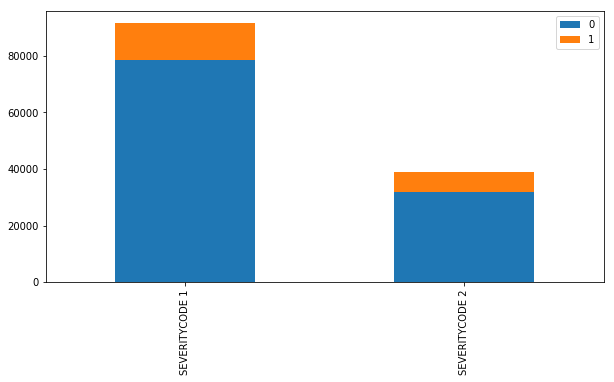

In [17]:
bar_chart(train, 'INATTENTIONIND')

In [18]:
train['PEDROWNOTGRNT'].value_counts()

Y    3163
Name: PEDROWNOTGRNT, dtype: int64

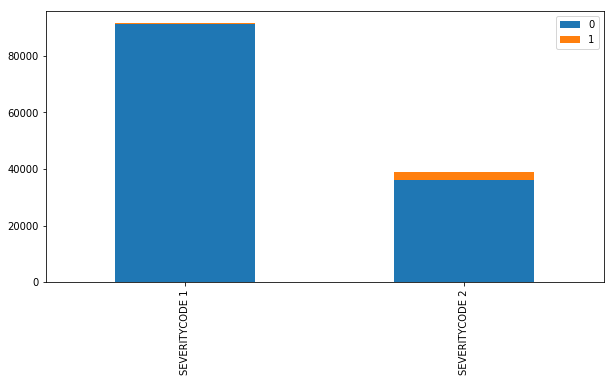

In [19]:
train['PEDROWNOTGRNT'] = train['PEDROWNOTGRNT'].replace(np.nan,0)
test['PEDROWNOTGRNT'] = test['PEDROWNOTGRNT'].replace(np.nan,0)

train['PEDROWNOTGRNT'] = train['PEDROWNOTGRNT'].replace('Y',1)
test['PEDROWNOTGRNT'] = test['PEDROWNOTGRNT'].replace('Y',1)
bar_chart(train, 'PEDROWNOTGRNT')

In [20]:
train['SPEEDING'].value_counts()

Y    6271
Name: SPEEDING, dtype: int64

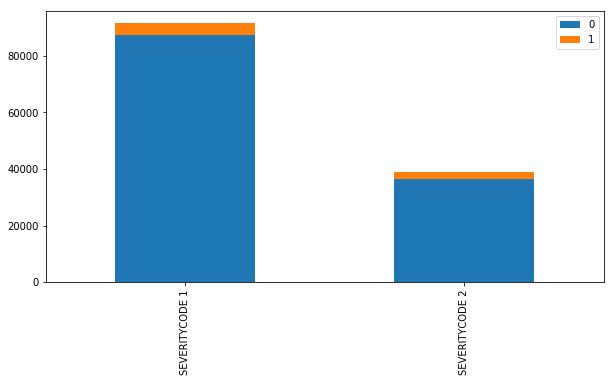

In [21]:
train['SPEEDING'] = train['SPEEDING'].replace(np.nan,0)
test['SPEEDING'] = test['SPEEDING'].replace(np.nan,0)

train['SPEEDING'] = train['SPEEDING'].replace('Y',1)
test['SPEEDING'] = test['SPEEDING'].replace('Y',1)
bar_chart(train, 'SPEEDING')

In [22]:
train['UNDERINFL'].value_counts()

N    67173
0    53846
Y     3392
1     2702
Name: UNDERINFL, dtype: int64

In [23]:
train['UNDERINFL'] = train['UNDERINFL'].replace('N',0)
train['UNDERINFL'] = train['UNDERINFL'].replace('Y',1)  
train['UNDERINFL'] = train['UNDERINFL'].replace('0',0) 
train['UNDERINFL'] = train['UNDERINFL'].replace('1',1) 

test['UNDERINFL'] = test['UNDERINFL'].replace('N',0)
test['UNDERINFL'] = test['UNDERINFL'].replace('Y',1)  
test['UNDERINFL'] = test['UNDERINFL'].replace('0',0) 
test['UNDERINFL'] = test['UNDERINFL'].replace('1',1) 

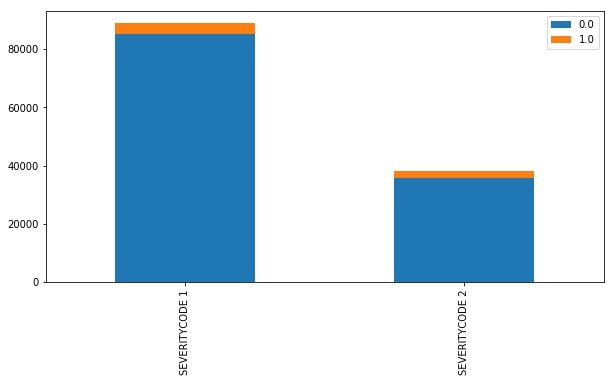

In [24]:
bar_chart(train, 'UNDERINFL')

In [25]:
train['LIGHTCOND'].value_counts()

Daylight                    77783
Dark - Street Lights On     32401
Unknown                      9092
Dusk                         3994
Dawn                         1669
Dark - No Street Lights      1015
Dark - Street Lights Off      809
Other                         155
Dark - Unknown Lighting         8
Name: LIGHTCOND, dtype: int64

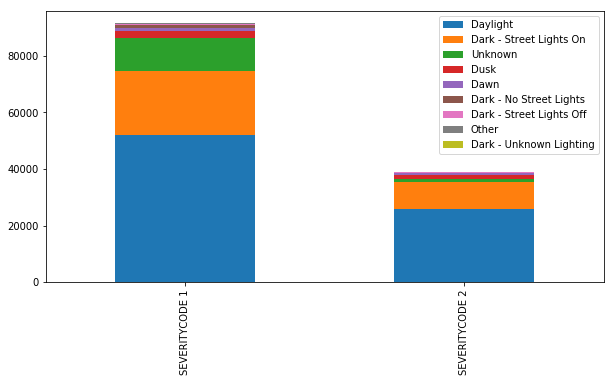

In [26]:
train['LIGHTCOND'] = train['LIGHTCOND'].replace(np.nan,'Unknown')
test['LIGHTCOND'] = test['LIGHTCOND'].replace(np.nan,'Unknown')

bar_chart(train, 'LIGHTCOND')

In [27]:
train['ROADCOND'].value_counts()

Dry               83405
Wet               31687
Unknown           10173
Ice                 812
Snow/Slush          691
Other                84
Standing Water       79
Sand/Mud/Dirt        51
Oil                  40
Name: ROADCOND, dtype: int64

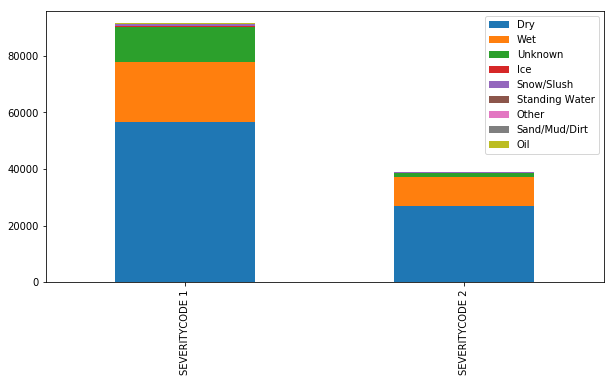

In [28]:
train['ROADCOND'] = train['ROADCOND'].replace(np.nan,'Unknown')
test['ROADCOND'] = test['ROADCOND'].replace(np.nan,'Unknown')
bar_chart(train, 'ROADCOND')

In [29]:
train['WEATHER'].value_counts()

Clear                       74348
Raining                     22215
Overcast                    18541
Unknown                     10177
Snowing                       619
Other                         557
Fog/Smog/Smoke                387
Sleet/Hail/Freezing Rain       75
Blowing Sand/Dirt              36
Severe Crosswind               17
Partly Cloudy                   5
Name: WEATHER, dtype: int64

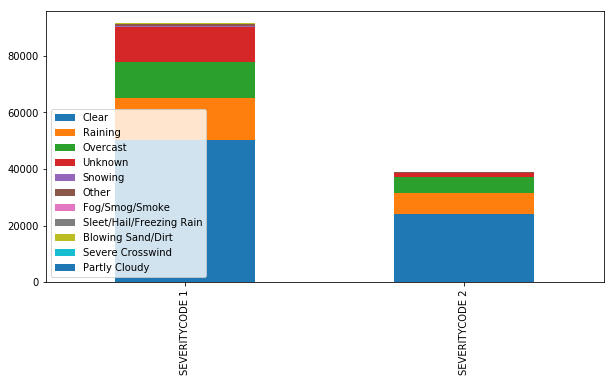

In [30]:
train['WEATHER'] = train['WEATHER'].replace(np.nan,'Unknown')
test['WEATHER'] = test['WEATHER'].replace(np.nan,'Unknown')
bar_chart(train, 'WEATHER')

# Treat dates

INCDATE contains the date of collision, it is already contained in INCDTTM

In [31]:
train['INCDTTM'] = pd.to_datetime(train['INCDTTM'])
test['INCDTTM'] = pd.to_datetime(test['INCDTTM'])

In [32]:
train = train.drop(['INCDATE'], axis=1)
test = test.drop(['INCDATE'], axis=1)

Check incidents by hour

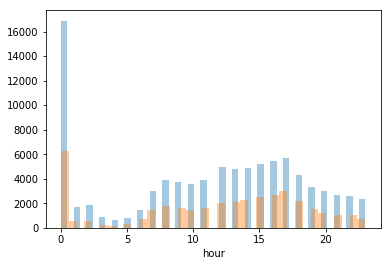

In [33]:
train['hour'] = train['INCDTTM'].dt.hour
test['hour'] = test['INCDTTM'].dt.hour

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['hour'],kde = False)

df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['hour'],kde = False)

Check day of the week

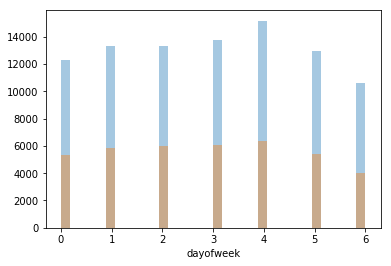

In [34]:
train['dayofweek'] = train['INCDTTM'].dt.dayofweek
test['dayofweek'] = test['INCDTTM'].dt.dayofweek

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['dayofweek'],kde = False)
df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['dayofweek'],kde = False)

Check month

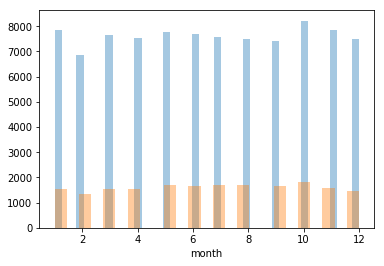

In [35]:
train['month'] = train['INCDTTM'].dt.month
test['month'] = test['INCDTTM'].dt.month

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['month'],kde = False)
df_selected = test[test['SEVERITYCODE']==2]
sns.distplot(df_selected['month'],kde = False)

Check year

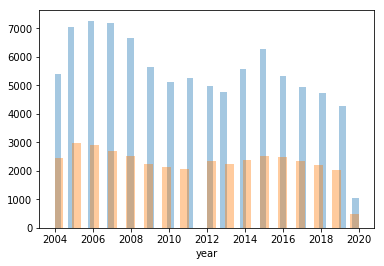

In [35]:
train['year'] = train['INCDTTM'].dt.year
test['year'] = test['INCDTTM'].dt.year

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['year'],kde = False)
df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['year'],kde = False)

Remove INCDTTM after saving dayofweek, month, hours, year

In [36]:
train = train.drop(['INCDTTM'], axis=1)
test = test.drop(['INCDTTM'], axis=1)

# Check outliers

In [37]:
details = computeDetails(train)
print(details)

                  types  counts  distincts  nulls  missing ration
X               float64  126901      20954   3529           2.706
Y               float64  126901      21200   3529           2.706
ADDRTYPE         object  129162          4   1268           0.972
PERSONCOUNT       int64  130430         44      0           0.000
PEDCOUNT          int64  130430          6      0           0.000
PEDCYLCOUNT       int64  130430          3      0           0.000
VEHCOUNT          int64  130430         12      0           0.000
JUNCTIONTYPE     object  128733          8   1697           1.301
INATTENTIONIND    int64  130430          2      0           0.000
UNDERINFL       float64  127113          3   3317           2.543
WEATHER          object  130430         11      0           0.000
ROADCOND         object  130430          9      0           0.000
LIGHTCOND        object  130430          9      0           0.000
PEDROWNOTGRNT     int64  130430          2      0           0.000
SPEEDING  

PERSONCOUNT   0   81
2     76565
3     23735
4      9859
1      8768
5      4453
0      3732
6      1828
7       759
8       345
9       150
10       86
11       34
12       17
13       15
14       10
15        9
17        7
16        6
44        5
19        4
26        4
18        3
20        3
47        3
34        3
22        2
23        2
24        2
25        2
29        2
21        2
32        2
36        2
54        1
37        1
43        1
41        1
39        1
30        1
31        1
28        1
27        1
81        1
57        1
Name: PERSONCOUNT, dtype: int64
PEDCOUNT   0   6
0    125818
1      4442
2       150
3        15
4         4
6         1
Name: PEDCOUNT, dtype: int64
PEDCYLCOUNT   0   2
0    126705
1      3700
2        25
Name: PEDCYLCOUNT, dtype: int64
VEHCOUNT   0   11
2     98861
1     17238
3      8721
0      3455
4      1666
5       342
6        96
7        30
8        10
9         7
11        3
10        1
Name: VEHCOUNT, dtype: int64
SEGLANEKEY   0   52524

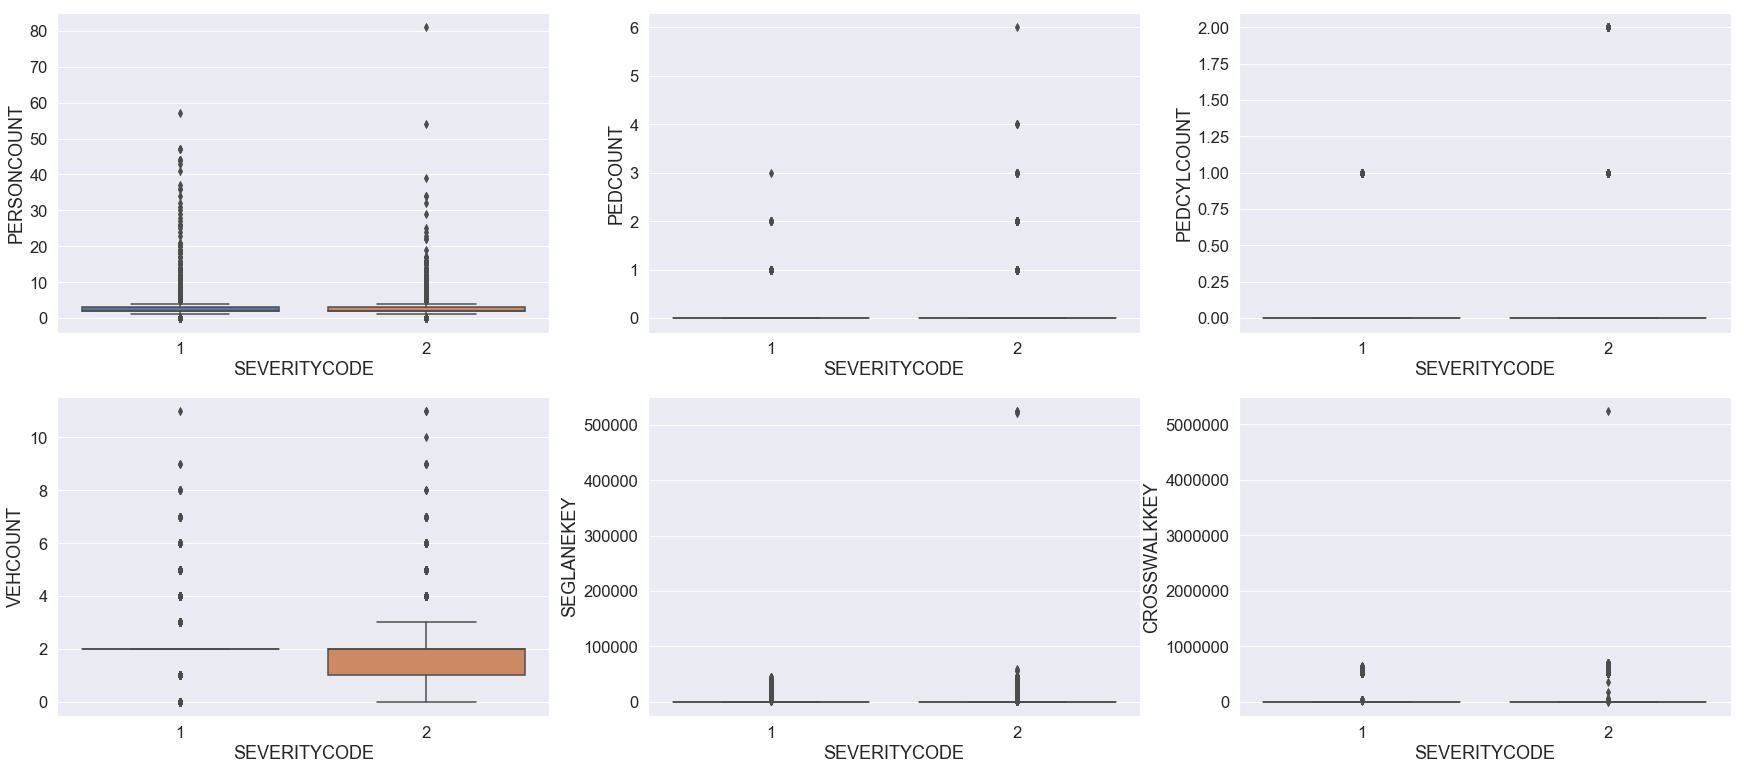

In [38]:
fig = plt.figure(figsize=(30, 20))
sns.set(font_scale=1.5)
key='PERSONCOUNT'
fig1 = fig.add_subplot(331); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='PEDCOUNT'
fig1 = fig.add_subplot(332); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())


key='PEDCYLCOUNT'
fig1 = fig.add_subplot(333); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='VEHCOUNT'
fig1 = fig.add_subplot(334); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='SEGLANEKEY'
fig1 = fig.add_subplot(335); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='CROSSWALKKEY'
fig1 = fig.add_subplot(336); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

plt.savefig('BoxPlots.jpg', dpi=300, bbox_inches='tight')

remove outliers

In [39]:
len_before = len(train)
train = train[train['PERSONCOUNT']<81]
train = train[train['SEGLANEKEY']<525241]
train = train[train['CROSSWALKKEY']<5239700]
len_after = len(train)
print("Num outliers removed ",len_before-len_after)

len_before = len(test)
test = test[test['PERSONCOUNT']<81]
test = test[test['SEGLANEKEY']<525241]
test = test[test['CROSSWALKKEY']<5239700]
len_after = len(test)
print("Num outliers removed ",len_before-len_after)

Num outliers removed  3
Num outliers removed  0


# Drop missing values

In [40]:
len_before = len(train)
train.dropna(inplace=True)
len_after = len(train)
print('percentage dropped ',(len_before - len_after)/len_before)

len_before = len(test)
test.dropna(inplace=True)
len_after = len(test)
print('percentage dropped ',(len_before - len_after)/len_before)

percentage dropped  0.05393055118955431
percentage dropped  0.056332985694939525


# Check correlations on numerical features

In [42]:
details = computeDetails(train)
print(details)

                  types  counts  distincts  nulls  missing ration
X               float64  123393      20554      0           0.000
Y               float64  123393      20792      0           0.000
ADDRTYPE         object  123393          2      0           0.000
PERSONCOUNT       int64  123393         43      0           0.000
PEDCOUNT          int64  123393          6      0           0.000
PEDCYLCOUNT       int64  123393          3      0           0.000
VEHCOUNT          int64  123393         12      0           0.000
JUNCTIONTYPE     object  123393          7      0           0.000
INATTENTIONIND    int64  123393          2      0           0.000
UNDERINFL       float64  123393          2      0           0.000
WEATHER          object  123393         11      0           0.000
ROADCOND         object  123393          9      0           0.000
LIGHTCOND        object  123393          9      0           0.000
PEDROWNOTGRNT     int64  123393          2      0           0.000
SPEEDING  

In [43]:
df_numerical = test[['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','SEGLANEKEY','CROSSWALKKEY','dayofweek','month','year']]

removed_columns=[]
correlation_threshold = 0.75
from scipy.stats import pearsonr
for c in df_numerical.columns:
    # column to preserve
    if c in removed_columns:
        continue
    # correlation with pval
    for cc in df_numerical.columns:
        corrtest = pearsonr(df_numerical[c], df_numerical[cc])
        corr = corrtest[0]
        pval = corrtest[1]
        if cc != c and cc not in removed_columns and corr > correlation_threshold and pval < 0.05:
            removed_columns.append(cc)

print(removed_columns)

[]


No relevant corelletions found

# Convert categorical to numerical

In [41]:
train['ADDRTYPE'], test['ADDRTYPE'] = prepare_categorical(train['ADDRTYPE'], test['ADDRTYPE'])
train['JUNCTIONTYPE'], test['JUNCTIONTYPE'] = prepare_categorical(train['JUNCTIONTYPE'], test['JUNCTIONTYPE'])
train['WEATHER'], test['WEATHER'] = prepare_categorical(train['WEATHER'], test['WEATHER'])
train['ROADCOND'], test['ROADCOND'] = prepare_categorical(train['ROADCOND'], test['ROADCOND'])
train['LIGHTCOND'], test['LIGHTCOND'] = prepare_categorical(train['LIGHTCOND'], test['LIGHTCOND'])
train['HITPARKEDCAR'], test['HITPARKEDCAR'] = prepare_categorical(train['HITPARKEDCAR'], test['HITPARKEDCAR'])

# Save cleaned up dataframe

In [42]:

train.to_csv('Data-Collisions-train.csv')
test.to_csv('Data-Collisions-test.csv')

# Load cleaned dataframe

In [43]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [44]:
train = pd.read_csv('Data-Collisions-train.csv')
train = train.drop(['Unnamed: 0'], axis=1)
train.dropna(inplace=True)
details = computeDetails(train)
print(details)

                  types  counts  distincts  nulls  missing ration
X               float64  123393      20554      0           0.000
Y               float64  123393      20792      0           0.000
ADDRTYPE          int64  123393          2      0           0.000
PERSONCOUNT       int64  123393         43      0           0.000
PEDCOUNT          int64  123393          6      0           0.000
PEDCYLCOUNT       int64  123393          3      0           0.000
VEHCOUNT          int64  123393         12      0           0.000
JUNCTIONTYPE      int64  123393          7      0           0.000
INATTENTIONIND    int64  123393          2      0           0.000
UNDERINFL       float64  123393          2      0           0.000
WEATHER           int64  123393         11      0           0.000
ROADCOND          int64  123393          9      0           0.000
LIGHTCOND         int64  123393          9      0           0.000
PEDROWNOTGRNT     int64  123393          2      0           0.000
SPEEDING  

In [45]:
test = pd.read_csv('Data-Collisions-test.csv')
test = test.drop(['Unnamed: 0'], axis=1)
test.dropna(inplace=True)
details = computeDetails(test)
print(details)

                  types  counts  distincts  nulls  missing ration
X               float64   60624      15916      0           0.000
Y               float64   60624      16063      0           0.000
ADDRTYPE          int64   60624          2      0           0.000
PERSONCOUNT       int64   60624         33      0           0.000
PEDCOUNT          int64   60624          5      0           0.000
PEDCYLCOUNT       int64   60624          3      0           0.000
VEHCOUNT          int64   60624         13      0           0.000
JUNCTIONTYPE      int64   60624          7      0           0.000
INATTENTIONIND    int64   60624          2      0           0.000
UNDERINFL       float64   60624          2      0           0.000
WEATHER           int64   60624         10      0           0.000
ROADCOND          int64   60624          9      0           0.000
LIGHTCOND         int64   60624          9      0           0.000
PEDROWNOTGRNT     int64   60624          2      0           0.000
SPEEDING  

In [46]:
#columns_to_dummify=['ADDRTYPE','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','HITPARKEDCAR']
#train = pd.get_dummies(train, columns=columns_to_dummify)
#test = pd.get_dummies(test, columns=columns_to_dummify)
#details = computeDetails(df)
#print(details)

# Decision tree model

In [47]:
y_train = train['SEVERITYCODE']
X_train= train.drop(['SEVERITYCODE'], axis=1)

y_test= test['SEVERITYCODE']
X_test= test.drop(['SEVERITYCODE'], axis=1)

In [48]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

train_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_test_scaled = train_scaler.transform(X_test)

In [49]:
clf = DecisionTreeClassifier(criterion="entropy", class_weight='balanced',random_state=42)
clf.fit(X_train_scaled, y_train) 
yhat = clf.predict(X_test_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6709140159098094

# Feature selection

In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [51]:
X_train_selected = X_train.drop(['X', 'Y'],axis=1)
X_test_selected = X_test.drop(['X', 'Y'],axis=1)
X_train_fs, X_test_fs, fs = select_features(X_train_selected, y_train, X_test_selected)
column_val =X_train_selected.columns.values
columns_to_drop=[]
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (column_val[i], fs.scores_[i]))
    if fs.scores_[i]<100:
        columns_to_drop.append(column_val[i])

Feature ADDRTYPE: 3323.620486
Feature PERSONCOUNT: 1410.298981
Feature PEDCOUNT: 7911.823383
Feature PEDCYLCOUNT: 5737.820523
Feature VEHCOUNT: 142.159143
Feature JUNCTIONTYPE: 3805.891968
Feature INATTENTIONIND: 189.149394
Feature UNDERINFL: 197.920453
Feature WEATHER: 3594.765200
Feature ROADCOND: 1320.193523
Feature LIGHTCOND: 263.278983
Feature PEDROWNOTGRNT: 5292.482217
Feature SPEEDING: 149.966483
Feature SEGLANEKEY: 56053682.488660
Feature CROSSWALKKEY: 2029171832.176309
Feature HITPARKEDCAR: 1256.850975
Feature hour: 333.721611
Feature dayofweek: 52.564809
Feature year: 1.162330


In [52]:
#columns_to_drop=['month','dayofweek','SPEEDING']
X_train_selected = X_train.drop(columns_to_drop,axis=1)
X_test_selected = X_test.drop(columns_to_drop,axis=1)

train_scaler = StandardScaler()
X_train_selected_scaled = train_scaler.fit_transform(X_train_selected)
X_test_selected_scaled = train_scaler.transform(X_test_selected)

In [53]:
clf = DecisionTreeClassifier(criterion="entropy", class_weight='balanced',random_state=42)
clf.fit(X_train_selected_scaled, y_train) 
yhat = clf.predict(X_test_selected_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6688516014289934

# XGBoost

In [54]:
yhat = clf.predict(X_test_selected_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6688516014289934

In [55]:
from sklearn.utils import class_weight
def ComputeWeights(y_val):
    sample_weights = class_weight.compute_class_weight('balanced', np.unique(y_val), y_val)
    weights = []
    y_train = np.array(y_val)
    for i in range(len(y_val)):
        if y_val[i] == 1:
            weights.append(sample_weights[0])
        elif y_val[i] == 2:
            weights.append(sample_weights[1])

    weights = np.array(weights)
    
    return weights

In [56]:
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

import xgboost as xgb
clf = xgb.XGBClassifier(n_jobs=3)

weights = ComputeWeights(y_train)
clf.fit(X_train_scaled, y_train,sample_weight=weights) 
yhat = clf.predict(X_test_scaled)
f1_score(y_test, yhat, average='weighted') 

d:\apps\python_3_7_4\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[1 2], y=[1 1 1 ... 2 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


0.6963916323525724

In [57]:
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print(current_accuracy)

0.6855205859065716
